![image](../../images/618_tutorials_banner_logos.png)

# Harmonized Landsat and Sentinel Tutorial
---
**Summary**

Welcome to the 618 Biospheric Lab Earth Observation tutorial GitHub! A repository that is in development to showcase useful remote sensing datasets, data processing skills, and analyses using datasets produced in-house (e.g., [GLiHT](https://gliht.gsfc.nasa.gov/)) and across NASA and other open source projects (e.g., Landsat and Sentinel-2).

This notebook demonstrates how to access [Harmonized Landsat-Sentinel 2 version 2 (HLS)](https://hls.gsfc.nasa.gov/) data from Google Earth Engine (GEE) using the GEE API. GEE offers a unique geospatial and remote sensing data processing toolkit that allows a user to query [available datasets](https://developers.google.com/earth-engine/datasets), perform computationally expensive processing and analyses server-side (i.e., not on your local computing resources, in this case the AWS SMCE instance), and extract sumamrized or compiled results. Using the GEE API in python can further improve accessibility by allowing users to leverage python-oriented geospatial libraries and without the need to use the GEE Javascript code editor.

In this notebook, we’ll walk through how to use GEE to access the complete HLSv2 record and compute meaningful spectral indices for time series analysis for the provided area of interest [The Great Dismal Swamp National Wildlife Resfuge](https://www.fws.gov/refuge/great-dismal-swamp).

**Learning Objectives**
- Access GEE datasets
- Interact with data without downloading it locally (server-side)
- Pre-process the HLS dataset
- Generate vegetation indices (NDVI, EVI)
- Perform a simple time series analysis
  
#### Contact Info**

**Author:** Colin Quinn (Github: [CQuinn8](https://github.com/cquinn8))
**Last Update:** 2025-12-16 (Created: 2025-11-01)  
**Website:** <https://github.com/GSFC-618/618-tutorials>


## Environment Setup 
**Environment:** conda env create -f [hls_tutorial-20251216.yaml](https://github.com/GSFC-618/618-tutorials/tree/main/envs)
 
**kernel:** global-global-airborne-core

In [1]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import MiniMap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from datetime import datetime, timedelta
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import STL
import statistics
import ee
import geemap

import re
import os
import json

# Authentication
To follow this tutorial, you will need a Google Earth Engine account, depending on your institution this may take time to create and project setup is not always intuitive. Once you have an account, you can use your credentials to access the gee API. If this is a problem, there will be an earthdata access equivalent to this tutorial in the future.

The cell below will attempt to authenticate and initialize the GEE API and store credentials in your local user `$HOME` directory with user-level read-write access. If you have not created a credentials file, the `ee.Authenticate()` function will provide a hyperlink with GEE instructions to set up your GEE project and generate a new API key. You will copy this key and paste it below. After authentication is complete for this project, the code block below will read the stored credentials to initialize the GEE API.

In [2]:
credentials_path = os.path.expanduser('~/.config/earthengine/credentials')

if not os.path.exists(credentials_path):
    print("No Earth Engine credentials found. Authenticating...")
    ee.Authenticate()
    ee.Initialize()
else:
    print("Found existing Earth Engine credentials.")
    try:
        ee.Initialize()
        print("Successfully initialized Earth Engine.")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        print("Re-authenticating...")
        ee.Authenticate()
        ee.Initialize()

Found existing Earth Engine credentials.
Successfully initialized Earth Engine.


In [3]:
# test authentication setup by querying the VIIRS Night Time Lights dataset and mapping over the Washington DC Metro
dataset = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG').filter(ee.Filter.date('2017-05-01', '2017-05-31')).first();
dataset.getInfo()

{'type': 'Image',
 'bands': [{'id': 'avg_rad',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [86400, 33600],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0041666667,
    0,
    -180.00208525335,
    0,
    -0.0041666667,
    75.00208393335001]},
  {'id': 'cf_cvg',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [86400, 33600],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0041666667,
    0,
    -180.00208525335,
    0,
    -0.0041666667,
    75.00208393335001]}],
 'version': 1502407417392000.0,
 'id': 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG/20170501',
 'properties': {'system:time_start': 1493596800000,
  'system:footprint': {'type': 'LinearRing',
   'coordinates': [[-180, -90],
    [180, -90],
    [180, 90],
    [-180, 90],
    [-180, -90]]},
  'system:time_end': 1496275200000,
  'system:asset_size': 10386705942,
  'system:index': '20170501'}}

In [4]:
vis_params = {
        'min': 0,
        'max': 60,
        'palette': ['000000', '444444', '888888', 'bbbbbb', 'ffffff']
    }
m = folium.Map(location=[39, -77], 
               zoom_start=8, 
               tiles='OpenStreetMap')
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Satellite',
    overlay=False,
    control=True
).add_to(m)
# Get Earth Engine tile URL
map_id = dataset.select('avg_rad').getMapId(vis_params)

# Add VIIRS layer 
folium.TileLayer(
    tiles=map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='VIIRS Nighttime Lights',
    overlay=True,
    control=True,
    opacity=0.7
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

m

In [ ]:
# USER DATA Setup

In [6]:
start_date = '2020-01-01'
end_date = '2025-01-01'
site_name = "GDSNWR" 
output_products = False # toggle to True to save plots locally
use_composite=False # NOTE: compositing is time consuming ~5 min for one small (<1km2) polygon/image collection for 10 years but helps with accounting for anomalous images

In [7]:
shp_file = "../../shapefiles/GDS_bound_box.shp" 

site_ID = Path(shp_file).stem
site_ID

'GDS_bound_box'

In [8]:
shp = gpd.read_file(shp_file)
shp = folium_compliant_gpd_shp(shp)
shp

,geometry
0,"POLYGON ((-76.57479 36.7779, -76.57479 36.4327..."


In [9]:
centroid = shp.geometry.union_all().centroid

m = folium.Map(
    [centroid.y, centroid.x], 
    zoom_start=10,
    control_scale=True,
)


folium.GeoJson(shp).add_to(m)
folium.LayerControl().add_to(m)
m

# Normalized Difference Vegetation Index (NDVI) & Enhanced Vegetation Index (EVI)
![ndvi](../../images/ndvi_example.jpg)

$\text{NDVI} = \frac{NIR - Red}{NIR + Red}$

EVI is more sensitive to differences in heavily vegetated areas (contrast) and helps correct for atmospheric haze.

EVI demonstrates a stronger relationship with carbon stocks

$\text{EVI} = 2.5 \times \frac{NIR - Red}{NIR + 6 \times Red - 7.5 \times Blue + 1}$


In [18]:
def folium_compliant_gpd_shp(gdf):
    for col in gdf.columns:
        if pd.api.types.is_datetime64_any_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(str)
    return gdf
    
def clean_gpd_column_name(column_name):
    """Make column names Earth Engine compatible by replacing dots, spaces, etc. with underscores"""
    clean_name = re.sub(r'[^a-zA-Z0-9]', '_', column_name)
    # Ensure it starts with a letter (EE requirement)
    if not clean_name[0].isalpha():
        clean_name = 'prop_' + clean_name
    return clean_name
    
def gdf_to_ee_fc(gdf):
    """Convert a GeoDataFrame to an Earth Engine FeatureCollection with clean property names."""
    # Create a mapping of old column names to EE-compatible names
    name_mapping = {col: clean_gpd_column_name(col) for col in gdf.columns if col != 'geometry'}
    
    # Rename columns in the GeoDataFrame
    gdf_clean = gdf.copy()
    gdf_clean.rename(columns=name_mapping, inplace=True)
    
    # Convert to GeoJSON
    geojson = json.loads(gdf_clean.to_json())
    
    # Create EE FeatureCollection
    ee_fc = ee.FeatureCollection(geojson)
    
    # Return both the FeatureCollection and name mapping for reference
    return ee_fc, name_mapping

# To add indices refer to Table 1 and Table 2: https://lpdaac.usgs.gov/documents/2088/HLS_VI_User_Guide_V2.pdf
def evi_calc(nir, red, blue):
    evi = nir.subtract(red).multiply(2.5).divide(
        nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)
    ).rename('EVI')
    return evi

def decode_fmask_to_category(image):
    fmask = image.select('Fmask')
    # boolean layers for each flag
    cirrus           = fmask.bitwiseAnd(1 << 0).neq(0) 
    cloud            = fmask.bitwiseAnd(1 << 1).neq(0) 
    adjacent_shadow  = fmask.bitwiseAnd(1 << 2).neq(0) 
    shadow           = fmask.bitwiseAnd(1 << 3).neq(0) 
    snow_ice         = fmask.bitwiseAnd(1 << 4).neq(0) 
    water            = fmask.bitwiseAnd(1 << 5).neq(0) 
    aerosol          = fmask.bitwiseAnd(1 << 6).neq(0) 
    high_aerosol     = fmask.bitwiseAnd(1 << 7).neq(0) 
    
    # Create categorical mask (priority-based)
    # Priority: cloud > shadow > snow > water > clear
    cat = ee.Image(0).rename('Fmask_cat')  # 0 = Clear
    cat = cat.where(water, 4)              # 4 = Water
    cat = cat.where(snow_ice, 3)           # 3 = Snow/Ice
    cat = cat.where(shadow.Or(adjacent_shadow), 2)  # 2 = Shadow
    cat = cat.where(cloud.Or(cirrus), 1)   # 1 = Cloud
    
    # Create a cloud mask (1 = clear, 0 = cloudy)
    cloud_mask = cloud.Or(shadow).Or(cirrus).Not()
    
    # Return results as new bands
    return image.addBands(cat.uint8()).addBands(cloud_mask.rename('cloud_mask'))
    
def process_hlsl(image):
    # Landsat-specific band handling
    qa = image.select('Fmask')
    qa_decoded = decode_fmask_to_category(qa)
    cloud_mask = qa_decoded.select('cloud_mask')

    nir = image.select('B5')  
    red = image.select('B4')
    green = image.select('B3')
    blue = image.select('B2')

    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    evi = evi_calc(nir, red, blue)
    
    # Add indices as bands
    image_with_indices = image.addBands([ndvi, evi])
    
    # Apply cloud mask
    masked_image = image_with_indices.updateMask(cloud_mask)
    
    # Mark the sensor
    return masked_image.set({
        'sensor': 'Landsat',
        'system:time_start': image.get('system:time_start')
    })

def process_hlss(image):
    # Sentinel-specific band handling
    qa = image.select('Fmask')
    qa_decoded = decode_fmask_to_category(qa)
    cloud_mask = qa_decoded.select('cloud_mask')
    
    nir = image.select('B8A')  
    red = image.select('B4')
    green = image.select('B3')
    blue = image.select('B2')

    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    evi = evi_calc(nir, red, blue)
    
    # Add indices as bands
    image_with_indices = image.addBands([ndvi, evi])
    
    # Apply cloud mask
    masked_image = image_with_indices.updateMask(cloud_mask)
    
    # Mark the sensor
    return masked_image.set({
        'sensor': 'Sentinel',
        'system:time_start': image.get('system:time_start')
    })
    
# generate polygon average time series for vegetation indices 
# (multiple images with multiple pixels -> average for ROI for each index for each image/date -> ROI-level veg index time series)
def extract_index_stats(image):
    """Extract statistics of vegetation indices over the ROI"""
    # Calculate mean values of indices within the ROI
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,  # HLS resolution is 30m
        maxPixels=1e9
    )
    
    # Get the date of the image
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    
    # Create a feature with the stats and date - commented out stats can be added easily
    return ee.Feature(None, {
        'date': date,
        'NDVI': stats.get('NDVI'),
        'EVI': stats.get('EVI'),
        # 'SAVI': stats.get('SAVI'),
        # 'NDMI': stats.get('NDMI'),
        # 'NDWI': stats.get('NDWI'),
        # 'NBR': stats.get('NBR'),
        # 'MSI': stats.get('MSI')
    })

# Function to create a monthly mosaic
def create_monthly_composite(year, month, hls_collection):
    # Define the date range for this month
    start_month = ee.Date.fromYMD(year, month, 1)
    end_month = start_month.advance(1, 'month')
    
    # Filter the collection to this month
    monthly_collection = hls_collection.filterDate(start_month, end_month)
    
    # Skip months with no images
    count = monthly_collection.size().getInfo()
    if count == 0:
        return None, None
    
    # Create a median composite for this month
    monthly_composite = monthly_collection.select(['NDVI', 'EVI']).median()
    
    # Add metadata
    date_str = f"{year}-{month:02d}"
    monthly_composite = monthly_composite.set({
        'year': year,
        'month': month,
        'date_str': date_str,
        'system:time_start': start_month.millis(),
        'image_count': count
    })
    
    return monthly_composite, date_str

In [19]:
# Format shapefile to GEE
geo_json = shp.to_json()
roi = ee.FeatureCollection(json.loads(geo_json))
roi, name_mapping = gdf_to_ee_fc(shp)

In [20]:
# Predefined visualization parameters for imagery
vis_params = {
    'Red': {'min': 0, 'max': 0.3, 'palette': ['black', '#FF0000', '#FF8080', '#FFCCCC', 'white']},
    'Green': {'min': 0, 'max': 0.3, 'palette': ['black', '#00FF00', '#80FF80', '#CCFFCC', 'white']},
    'Blue': {'min': 0, 'max': 0.3, 'palette': ['black', '#0000FF', '#8080FF', '#CCCCFF', 'white']},
    'NIR': {'min': 0, 'max': 0.6, 'palette': ['black', '#303030', '#606060', '#909090', '#C0C0C0', 'white']},
    'NDVI': {'min': -0.2, 'max': 0.9, 'palette': ['#7F0000', '#994C00', '#FFFF00', '#006600']},
    'EVI': {'min': -0.1, 'max': 0.7, 'palette': ['#FFFFFF', '#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901', '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01', '#012E01', '#011D01', '#011301']},
    'RGB': {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3},
    'ColorInfrared': {
        'bands': ['B5', 'B4', 'B3'],  # NIR, R, G
        'min': 0,
        'max': 0.4
    },
    'SWIR': {
        'bands': ['B6', 'B5', 'B4'],  # SWIR1, NIR, R
        'min': 0,
        'max': 0.4
    },
    'CloudMask': {
        'bands': ['Fmask'],
        'min': 0,
        'max': 4,
        'palette': ['black', 'white', 'blue', 'yellow', 'red']
    }
}

In [21]:
def count_valid_pixels(img):
    # Count unmasked pixels within the clipped ROI
    valid = img.mask().reduce(ee.Reducer.sum())
    # multi-band mask → reduce to scalar
    valid = valid.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=30,
        maxPixels=1e13
    ).values().get(0)
    
    # Store the count as metadata so we can filter on it
    return img.set('valid_pixel_count', valid)

In [22]:
# Get both HLS collections
hlsl30 = (
    ee.ImageCollection('NASA/HLS/HLSL30/v002')
    .filterDate(start_date, end_date)
    # filter images with total image cloud coverge before processing
    # .filter(ee.Filter.lt('CLOUD_COVERAGE', 70))
    .filterBounds(roi)
    .map(process_hlsl)  
    .limit(500) 
)

hlss30 = (
    ee.ImageCollection('NASA/HLS/HLSS30/v002')
    .filterDate(start_date, end_date)
    # .filter(e.Filter.lt('CLOUD_COVERAGE', 70))
    .filterBounds(roi)
    .map(process_hlss)
    .limit(500) 
)

# Merge the collections
hls_combined = (hlsl30.merge(hlss30) 
                .sort('system:time_start')
               )

hls_clipped = (hls_combined.map(lambda img: img.clip(roi))
               .map(count_valid_pixels))

hls_filtered = hls_clipped.filter(ee.Filter.gt('valid_pixel_count', 0))

In [23]:
# print the number of valid pixels in each image that overlaps the ROI (highlights images with cloud cover)
#counts = hls_clipped.aggregate_array('valid_pixel_count').getInfo()
#print(counts)

In [24]:
if use_composite:
    composites_list = []
    dates = []
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')

    # Create a list of all year-month combinations
    date_list = []
    current = start_dt.replace(day=1)
    while current <= end_dt:
        date_list.append((current.year, current.month))
        if current.month == 12:
            current = current.replace(year=current.year+1, month=1)
        else:
            current = current.replace(month=current.month+1)

    for year, month in date_list:
        if month == 1:
            print(year)
        composite_image, date_str = create_monthly_composite(year, month, hls_clipped)
        
        if composite is not None:
            composites_list.append(composite_image)
            dates.append(date_str)
    
    print(f"Composite HLS images: {len(composites_list)}")

The following code blocks takes the server-side preprocessing we coded above, executes it server-side, and brings the data to us, the client using the function `getInfo()`. 

Depending on the number of images (e.g., >1,000) this may 1) take a few minutes or 2) fail if there are too many images. If you have <1,000 images in your `hls_combined` dataset and the `hls_filtered` code does not progress in either of the two blocks below within 5 min, restart your kernel and try again. The following two cells are the more time-intensive steps, compute-wise.

In [25]:
# Now you have the complete HLS dataset with full temporal density
print(f"HLSL30 images: {hlsl30.size().getInfo()}")
print(f"HLSS30 images: {hlss30.size().getInfo()}")

# the harmonized dataset
print(f"Combined HLS images: {hls_combined.size().getInfo()}")

# removed images with 0 valid pixels in the ROI due to QA/QC/cloud band filter mask
print(f"High quality, cloud free HLS images: {hls_filtered.size().getInfo()}")

HLSL30 images: 328
HLSS30 images: 500
Combined HLS images: 828
High quality, cloud free HLS images: 502


In [26]:
# Apply image summary function to all images and get a feature collection containing average index value for each date/image
index_stats = ee.FeatureCollection(hls_filtered.map(extract_index_stats))

# Export the time series as a list of dictionaries
time_series = index_stats.getInfo()['features']

# Convert to DataFrame for analysis
df_indices = pd.DataFrame([feat['properties'] for feat in time_series])
df_indices['date'] = pd.to_datetime(df_indices['date'])
df_indices = df_indices.set_index('date').sort_index()

# Visualize site polygon and summer NDVI & EVI 

In [37]:
temp_start_date="2022-05-01"
temp_end_date="2022-09-01"

valid_image = hls_filtered.filterDate(temp_start_date, temp_end_date).first()
valid_image_date = ee.Date(valid_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
print(f"Image date: {valid_image_date}")

test_image = hls_filtered.filterDate(valid_image_date, 
                                     ee.Date(valid_image_date).advance(1, 'day')).first()

Image date: 2022-05-01


In [39]:
# Create a Folium map
m = folium.Map(
    location=[centroid.y, centroid.x], 
    zoom_start=11,
    control_scale=True,
)

# Print image details for reference
print(f"Image bands: {test_image.bandNames().getInfo()}")

sensor = test_image.get('sensor').getInfo()
if sensor == 'Sentinel':
    nir_band = 'B8A'
    print("\nUsing Sentinel band specfications")
else:
    nir_band = 'B5'
    print("\nUsing Landsat band specifications")

print("\nAdding RGB visualization...")
rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}
rgb_map_id = test_image.visualize(**rgb_vis).getMapId()
folium.raster_layers.TileLayer(
    tiles=rgb_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='RGB Natural Color',
    overlay=True,
    control=True
).add_to(m)



print(f"\nUsing {nir_band} for NIR band")
nir = test_image.select(nir_band)
nir_vis = {'min': 0, 'max': 0.6, 'palette': ['black', 'white']}
nir_map_id = nir.visualize(**nir_vis).getMapId()
folium.raster_layers.TileLayer(
    tiles=nir_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name=f'NIR Band ({nir_band})',
    overlay=True,
    control=True
).add_to(m)

# Add NDVI 
print("\nAdding NDVI...")
#ndvi = test_image.normalizedDifference([nir_band, 'B4']).rename('NDVI')
ndvi = test_image.select('NDVI')
ndvi_vis = {'min': -0.2, 'max': 0.9, 'palette': ['brown', 'yellow', 'green']}
ndvi_map_id = ndvi.visualize(**ndvi_vis).getMapId()

folium.raster_layers.TileLayer(
    tiles=ndvi_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='NDVI',
    overlay=True,
    control=True
).add_to(m)

# Add EVI 
print("\nAdding EVI...")
evi = test_image.select('EVI')
evi_vis = {'min': -0.2, 'max': 0.9, 'palette': ['brown', 'yellow', 'green']}
evi_map_id = evi.visualize(**evi_vis).getMapId()
folium.raster_layers.TileLayer(
    tiles=evi_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='EVI',
    overlay=True,
    control=True
).add_to(m)

# Add shape file
try:
    folium.GeoJson(
        shp,
        name='ROI',
        style_function=lambda x: {
            'fillColor': 'transparent',
            'color': 'red',
            'weight': 2
        }
    ).add_to(m)
    print("\nROI shape added")
except Exception as e:
    print(f"\nError adding ROI shape: {e}")
    
# Add layer control
folium.LayerControl(collapsed=False).add_to(m)
if output_products:
    # Add a title with explanatory information
    title_html = f"""
    <div style="position: fixed; 
                top: 10px; left: 10px; width: 300px; 
                background-color: white; border-radius: 5px;
                z-index: 900; font-size: 14px; padding: 10px;
                font-family: Arial;
                border: 2px solid grey;">
        <b>Visualization site HLS RGB and NDVI</b><br>
        Image Date: {ee.Date(test_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()}
    </div>
    """
    m.get_root().html.add_child(folium.Element(title_html))
    # Save the map to HTML
    m.save(f"./map-{site_name}-{site_ID}.html")
    print(f"\nMap has been saved to ./map-{site_name}-{site_ID}.html")

# Display the map in our notebook
print("\nDisplaying the map...")
display(m)

Image bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'Fmask', 'SZA', 'SAA', 'VZA', 'VAA', 'NDVI', 'EVI']
Using Landsat band specifications

Adding RGB visualization...

Using B5 for NIR band

Adding NDVI...

Adding EVI...

ROI shape added

Displaying the map...


# Visualize the quality ROI timeseries vegetation indices

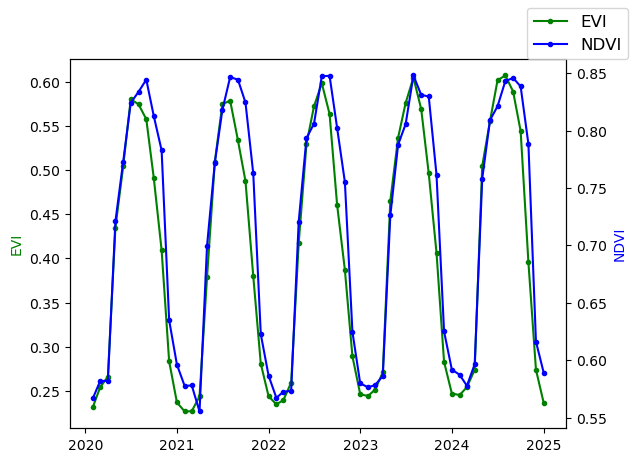

In [49]:
# Calculate averages for visualization
monthly_avg = df_indices.resample('ME').median()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(monthly_avg.index, monthly_avg['EVI'], label='EVI', color = 'g', marker = '.')
ax2.plot(monthly_avg.index, monthly_avg['NDVI'], label='NDVI', color = 'b', marker = '.')
ax1.set_ylabel('EVI', color='g')
ax2.set_ylabel('NDVI', color='b')
fig.legend(loc='upper right', fontsize=12)
plt.show()

**Note**: the time series can be discontinuous in some cases where cloud cover or image quality leads to no images for a given month. If there are gaps, this can lead to errors in time series analysis. By using a median monthly average we are ignoring data QC/QA. If data are plotted for each image, users can see erroneous values in EVI and NDVI for individual dates.

In [50]:
df_indices.head()

,EVI,NDVI
date,,
2020-01-01,0.228654,0.566797
2020-01-06,0.223007,0.572166
2020-01-11,0.306184,0.523380
2020-01-26,0.231674,0.575193
2020-01-28,0.243558,0.564242


Looking at the `df_indices` table we can see that the spacing among the dates is irregular. This is because, for speed's sake we didn't generate a composite for each month/season. This is a computationally expensive process that is toggled on or off earlier in the code. For our purpose here we are going to generate a monthly average of values - in a science method we would take a composite (average) of the actual remote sensing imagery after a complete QA/QC so that we have a quality single pixel value for each month that is used to compute environmental indices.

In [51]:
# resample('ME') will gap fill any missing months with NaN but adds a row to our df. 
# This is good! Because for our time series analysis we are going to rely on the 
# spacing of the dates for a measure of periodicity (seasonal/interannual)
indices_month = df_indices.resample('ME').median()
indices_month.head()

,EVI,NDVI
date,,
2020-01-31,0.231674,0.566797
2020-02-29,0.254116,0.581815
2020-03-31,0.266285,0.582195
2020-04-30,0.434799,0.720874
2020-05-31,0.504462,0.772979


In [52]:
longest_gap = indices_month['EVI'].isna().astype(int).groupby(indices_month['EVI'].notna().astype(int).cumsum()).sum().max()
print(longest_gap)

0


In [53]:
# We can create a coarser period for our time series which will provide a continuous time series most likely
indices_seas = df_indices.resample('QE').median()
indices_seas.head()

,EVI,NDVI
date,,
2020-03-31,0.242097,0.571877
2020-06-30,0.523083,0.786974
2020-09-30,0.555156,0.836233
2020-12-31,0.266314,0.634463
2021-03-31,0.228280,0.568044


We will use a quick approach to gap fill our data first by interpolating the data. If our longest gap is 1, the interpolation alone will be sufficient. Otherwise we will use a climatology informed interpolation.
  
**Note:** this is a critical step for statistical validity and should follow proper methodology, this is not that


In [54]:
df_interp = indices_month.interpolate(method='time')

# Now fill any remaining large gaps with climatology
clim = indices_month.groupby(indices_month.index.month).mean()
df_filled = df_interp.copy()

if longest_gap > 1:
    for m in range(1, 13):
        df_filled.loc[df_filled.index.month==m] = \
            df_filled.loc[df_filled.index.month==m].fillna(clim.loc[m])
    len(df_interp[(df_interp['EVI'] - df_filled['EVI']) > 0])

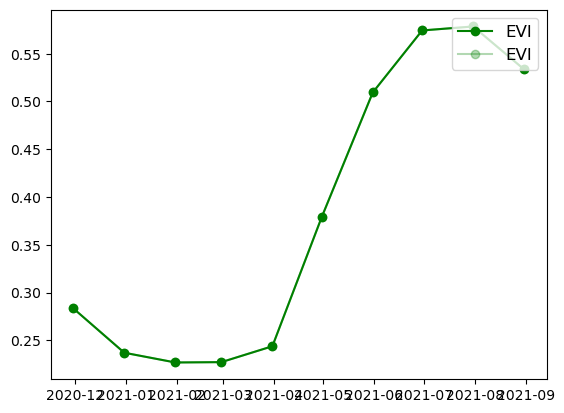

In [55]:
# EVI - highlight single point interpolation
fig, ax = plt.subplots()
ax.plot(indices_month.index[10:20], indices_month['EVI'][10:20], label='EVI', color = 'g', marker = 'o')
ax.plot(df_filled.index[10:20], df_filled['EVI'][10:20], label='EVI', color = 'g', marker = 'o', alpha = 0.3)
ax.legend(loc='upper right', fontsize=12)
plt.show()

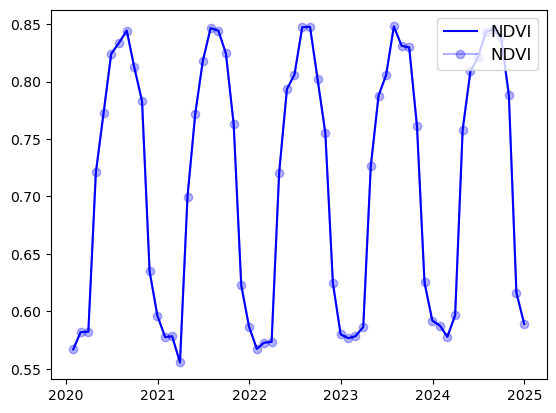

In [56]:
# NDVI - full time series
fig, ax = plt.subplots()
ax.plot(indices_month.index, indices_month['NDVI'], label='NDVI', color = 'b')
ax.plot(df_filled.index, df_filled['NDVI'], label='NDVI', color = 'b', marker = 'o', alpha = 0.3)
ax.legend(loc='upper right', fontsize=12)
plt.show()

# Detrend seasonal time series and Identify anomalies

We will use a simple detrending algorithm to decompose our monthly interannual (e.g., 2016-2025) time series.

This approach will provide the long term, interannual trend (period = 12), the seasonal trend based on the period, and the remaining residuals.

With our annual data we anticipate there may be an interannual trend (or not) and that the seasonal trend will remove the periodicity in the time series (the transition of vegetation productivity between growth and dormancy)

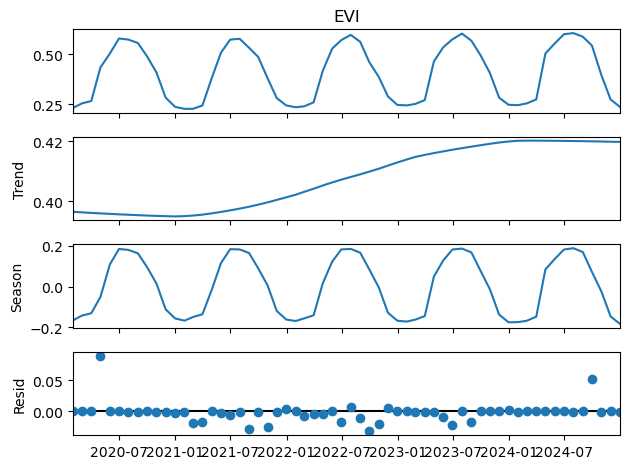

In [58]:
stl = STL(df_filled['EVI'], period=12, robust=True) 
result = stl.fit()

fig = result.plot()
if output_products:
    plt.savefig(f'./trend-{site_name}-{site_ID}.png')
plt.show()

<Axes: ylabel='Frequency'>

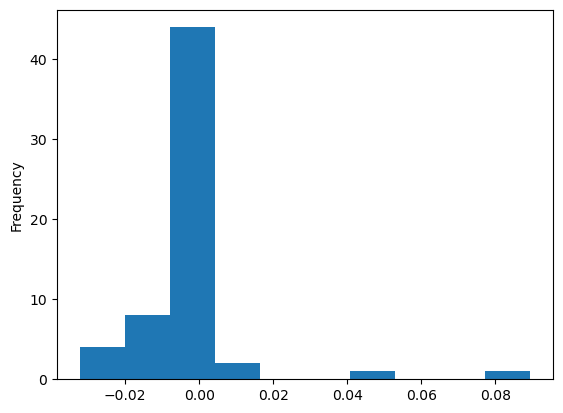

In [59]:
# analyse the residuals to assess normalcy
result.resid.plot.hist()

In [60]:
anom_stdev = statistics.stdev(result.resid)
anom_stdev

0.016305321922307905

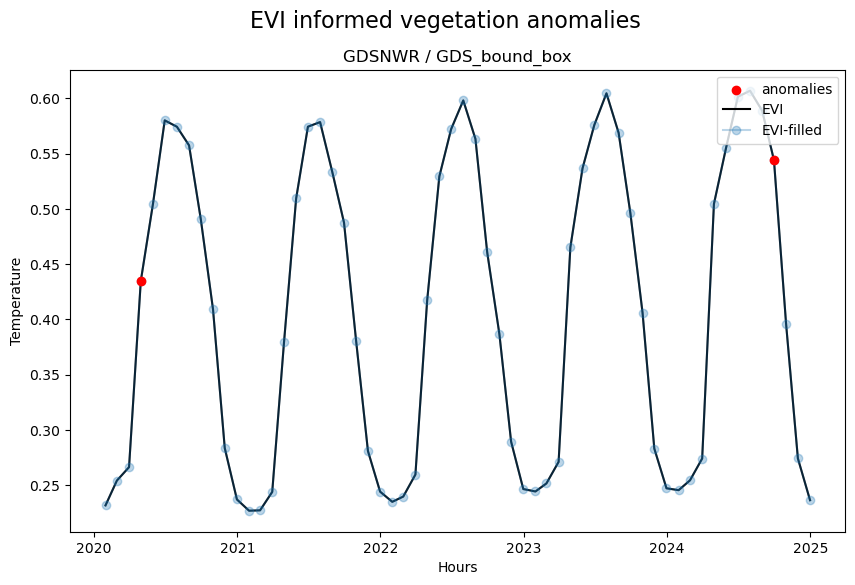

In [61]:
# visualize anomalies above/below 2sd 
threshold = anom_stdev * 2
anomalies_filter = result.resid.apply(lambda x: True if abs(x) > threshold else False)
anomalies = df_filled['EVI'][anomalies_filter]
plt.figure(figsize=(10, 6))

plt.scatter(x=anomalies.index, y=anomalies, color="red", label="anomalies", zorder=3)
plt.plot(indices_month.index, indices_month['EVI'], label='EVI', color = 'black')
plt.plot(df_filled.index, df_filled['EVI'], label='EVI-filled', marker = 'o', alpha = 0.3)

plt.suptitle(f'EVI informed vegetation anomalies', size = 16)
plt.title(f'{site_name} / {site_ID}')
plt.xlabel('Hours')
plt.ylabel('Temperature')
plt.legend(loc='upper right')

if output_products:
    plt.savefig(f'./anomalies-{site_name}-{site_ID}.png')
plt.show()